In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Load your datasets
train_df = pd.read_csv('/content/drive/MyDrive/UJIndoorLoc/trainingData.csv')
test_df = pd.read_csv('/content/drive/MyDrive/UJIndoorLoc/validationData.csv')

X_train = train_df.drop(['LATITUDE','LONGITUDE'], axis=1).values
y_train = train_df[['LATITUDE','LONGITUDE']].values

X_test = test_df.drop(['LATITUDE','LONGITUDE'], axis=1).values
y_test = test_df[['LATITUDE','LONGITUDE']].values

# Convert to PyTorch tensors
tensor_x_train = torch.tensor(X_train, dtype=torch.float32)
tensor_y_train = torch.tensor(y_train, dtype=torch.float32)

tensor_x_test = torch.tensor(X_test, dtype=torch.float32)
tensor_y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Bayesian Neural Network

In [ ]:
pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
!pip install blitz-bayesian-pytorch seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

@variational_estimator
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size = 64  # Adjusted to better handle high-dimensional input # Previousl Valueed at 512


        self.blinear1 = BayesianLinear(527, hidden_size, prior_sigma_1=1)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size, prior_sigma_1=1)
        # Output size set to 2 for LATITUDE and LONGITUDE
        self.blinear3 = BayesianLinear(hidden_size, 2, prior_sigma_1=1)

    def forward(self, x):
        x_ = torch.relu(self.blinear1(x))
        x_ = torch.relu(self.blinear2(x_))
        return self.blinear3(x_)

In [ ]:
import matplotlib.pyplot as plt
def make_plot_bnn(model, tensor_x_test, x_test_indices, samples=500):
    model.eval()
    preds = [model(tensor_x_test) for _ in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().cpu().numpy()
    stds = preds.std(axis=0).detach().cpu().numpy()

    sorted_indices = x_test_indices.argsort()
    x_sorted = x_test_indices[sorted_indices]

    # Plotting Part
    fig, axs = plt.subplots(2, 1, figsize=(10, 14))

    for i, target in enumerate(['LATITUDE', 'LONGITUDE']):
        mean = means[:, i][sorted_indices]
        std = stds[:, i][sorted_indices]
        axs[i].fill_between(x_sorted, (mean - 2 * std), (mean + 2 * std), color='lightgrey', label='Uncertainty Interval (±2 std)')
        axs[i].plot(x_sorted, mean, label='Mean Prediction')
        axs[i].set_title(f'Predictions and Uncertainty for {target}')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel(target)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
x_test_indices = np.arange(len(tensor_x_test))  # Simple range array

In [ ]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bnn = BayesianNetwork().to(device)
optimizer = optim.Adam(bnn.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
bnn.train()
for epoch in range(100):  # Future Developer can adjust the number of epochs if they want to yield better performance
    total_loss = 0
    for batch in train_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        loss = bnn.sample_elbo(inputs=x,
                               labels=y,
                               criterion=criterion,
                               sample_nbr=3,  # Adjust sampling number if necessary
                               complexity_cost_weight=0.01/len(train_dataset))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader)}")

Epoch 0, Loss: 14780436141925.744
Epoch 10, Loss: 6157380053.794871
Epoch 20, Loss: 1586640296.0416667
Epoch 30, Loss: 446600002.83092946
Epoch 40, Loss: 358710787.16225964
Epoch 50, Loss: 356798511.255609
Epoch 60, Loss: 383902196.59615386
Epoch 70, Loss: 1008992646.7724359
Epoch 80, Loss: 550952554.9671475
Epoch 90, Loss: 340879846.6422276


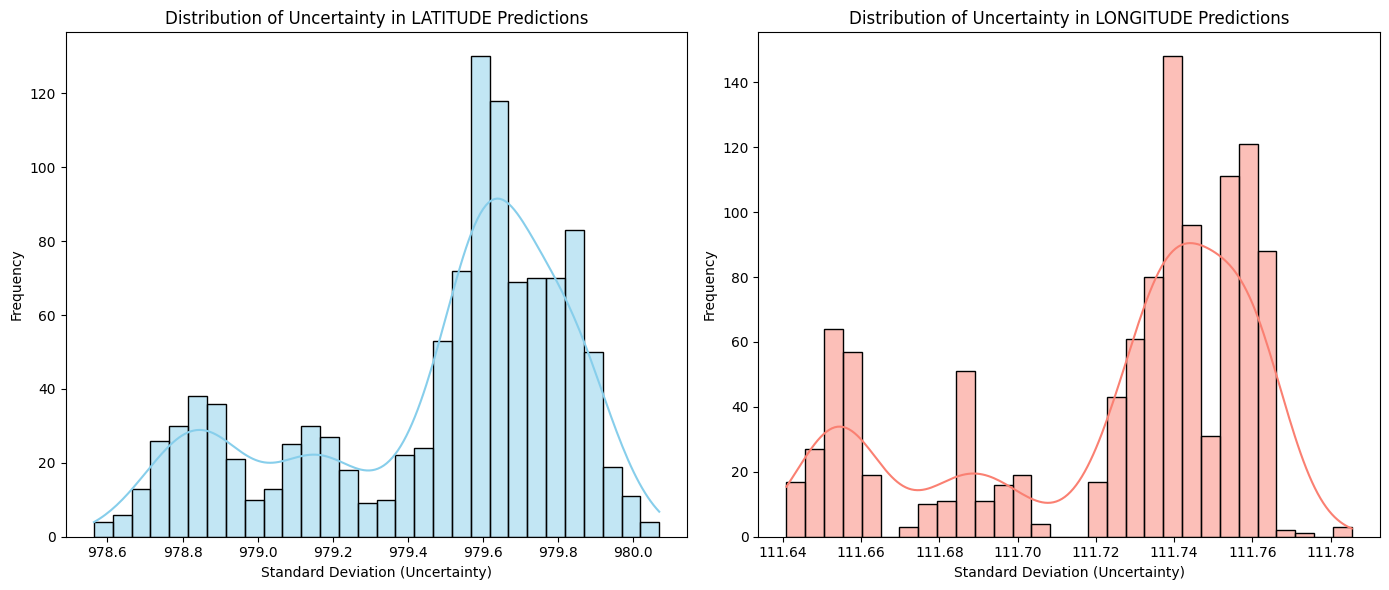

In [ ]:
import seaborn as sns
def plot_uncertainty_distribution(model, tensor_x_test, samples=100):
    model.eval()
    tensor_x_test = tensor_x_test.to(device)  # Ensure tensor is on the correct device
    with torch.no_grad():
        preds = torch.stack([model(tensor_x_test) for _ in range(samples)])

    # Calculate standard deviation across samples to get uncertainty
    stds = preds.std(dim=0).cpu().numpy()
    lat_std, lon_std = stds[:, 0], stds[:, 1]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plotting the distribution of uncertainties for LATITUDE
    sns.histplot(lat_std, bins=30, kde=True, ax=axs[0], color='skyblue')
    axs[0].set_title('Distribution of Uncertainty in LATITUDE Predictions')
    axs[0].set_xlabel('Standard Deviation (Uncertainty)')
    axs[0].set_ylabel('Frequency')

    # Plotting the distribution of uncertainties for LONGITUDE
    sns.histplot(lon_std, bins=30, kde=True, ax=axs[1], color='salmon')
    axs[1].set_title('Distribution of Uncertainty in LONGITUDE Predictions')
    axs[1].set_xlabel('Standard Deviation (Uncertainty)')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_uncertainty_distribution(bnn, tensor_x_test)

# Monte Carlo Dropout

In [ ]:
import torch.nn.functional as F
class MCDropoutModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(MCDropoutModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
import torch
# Initialize the model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MCDropoutModel(input_size=527, hidden_size=64, output_size=2, dropout_rate=0.5).to(device)
criterion = nn.MSELoss()

# Adjust learning rate if needed
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Placeholder for loss logging, do not remove this one.
losses = []

# Training loop
model.train()
for epoch in range(100):
    epoch_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute MSE loss
        mse_loss = criterion(outputs, targets)

        # We can add a regularization term.this is a simple L2 regularization:
        l2_lambda = 0.001
        l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
        loss = mse_loss + l2_lambda * l2_reg

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log the average loss for the epoch
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

Epoch 1, Loss: 2915859759104.0000
Epoch 2, Loss: 1644360056884.5129
Epoch 3, Loss: 1724273622829.9487
Epoch 4, Loss: 1746909808114.8718
Epoch 5, Loss: 1752068822252.3076
Epoch 6, Loss: 1817196471169.6411
Epoch 7, Loss: 1987814297494.9744
Epoch 8, Loss: 1941272462992.4102
Epoch 9, Loss: 2205210172389.7437
Epoch 10, Loss: 2270676292739.2822
Epoch 11, Loss: 2219340221623.7949
Epoch 12, Loss: 2241267838578.8716
Epoch 13, Loss: 2209519473165.1284
Epoch 14, Loss: 4122423246637.9487
Epoch 15, Loss: 4063121136403.6924
Epoch 16, Loss: 4083317502477.1284
Epoch 17, Loss: 4024024370254.7690
Epoch 18, Loss: 4105456089455.5898
Epoch 19, Loss: 4064149698297.4360
Epoch 20, Loss: 4065804834868.5127
Epoch 21, Loss: 4089632186578.0513
Epoch 22, Loss: 4053165526934.9741
Epoch 23, Loss: 4047338376638.3589
Epoch 24, Loss: 4135915124263.3848
Epoch 25, Loss: 4100580137117.5386
Epoch 26, Loss: 4104171656342.9741
Epoch 27, Loss: 4118288359424.0000
Epoch 28, Loss: 4095490238516.5127
Epoch 29, Loss: 4080141137867

In [ ]:
def mc_dropout_predict(model, input_tensor, n_samples=100):
    model.train()
    predictions = [model(input_tensor) for _ in range(n_samples)]
    predictions = torch.stack(predictions)
    mean_predictions = predictions.mean(0)
    std_predictions = predictions.std(0)
    return mean_predictions, std_predictions

model.eval()
input_tensor = tensor_x_test.to(device)
mean_predictions, std_predictions = mc_dropout_predict(model, input_tensor)
model.train()

MCDropoutModel(
  (fc1): Linear(in_features=527, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def plot_uncertainty_distribution_mc_dropout(model, tensor_x_test, samples=100):
    device = next(model.parameters()).device
    tensor_x_test = tensor_x_test.to(device)
    model.train()

    # Perform multiple forward passes to simulate MC Dropout
    with torch.no_grad():
        preds = torch.stack([model(tensor_x_test) for _ in range(samples)])

    # Calculate standard deviation across samples to get uncertainty
    stds = preds.std(dim=0).cpu().numpy()
    lat_std, lon_std = stds[:, 0], stds[:, 1]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plotting the distribution of uncertainties for LATITUDE
    sns.histplot(lat_std, bins=30, kde=True, ax=axs[0], color='skyblue')
    axs[0].set_title('Distribution of Uncertainty in LATITUDE Predictions')
    axs[0].set_xlabel('Standard Deviation (Uncertainty)')
    axs[0].set_ylabel('Frequency')

    # Plotting the distribution of uncertainties for LONGITUDE
    sns.histplot(lon_std, bins=30, kde=True, ax=axs[1], color='salmon')
    axs[1].set_title('Distribution of Uncertainty in LONGITUDE Predictions')
    axs[1].set_xlabel('Standard Deviation (Uncertainty)')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

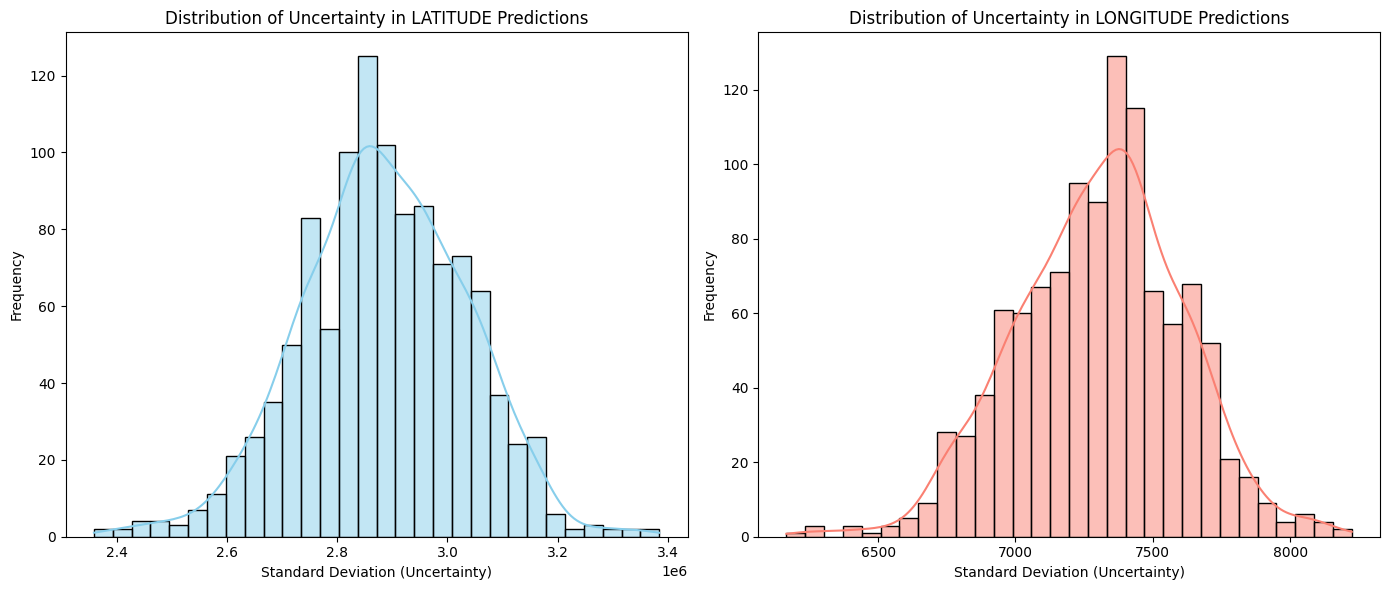

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plot_uncertainty_distribution_mc_dropout(model, tensor_x_test)

# Trying Deep Ensemble Technique using SimpleNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.output(x)
        return x

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = X_train.shape[1]
num_models = 5
# Initialize the ensemble
ensemble_models = [SimpleNet(input_size=input_size).to(device) for i in range(num_models)]

In [ ]:
# Training parameters
epochs = 100
learning_rate = 0.001
optimizers = [optim.Adam(model.parameters(), lr=learning_rate) for model in ensemble_models]

# Loss function
criterion = nn.MSELoss()

# Placeholder for loss logging
ensemble_losses = []

# Training loop
for epoch in range(epochs):
    epoch_losses = []
    for model, optimizer in zip(ensemble_models, optimizers):
        model.train()
        batch_losses = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            mse_loss = criterion(output, target)

            lambda_reg = 1e-4
            l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
            loss = mse_loss + lambda_reg * l2_reg

            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        epoch_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_loss)
    ensemble_loss = sum(epoch_losses) / len(epoch_losses)
    ensemble_losses.append(ensemble_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Ensemble Loss: {ensemble_loss:.4f}')

Epoch 0, Ensemble Loss: 150278122227.4896
Epoch 10, Ensemble Loss: 1042623534.8031
Epoch 20, Ensemble Loss: 204193022.0369
Epoch 30, Ensemble Loss: 54300397.8630
Epoch 40, Ensemble Loss: 86823326.8597
Epoch 50, Ensemble Loss: 41109143.7979
Epoch 60, Ensemble Loss: 36332517.8814
Epoch 70, Ensemble Loss: 40418361.4877
Epoch 80, Ensemble Loss: 35114019.9548
Epoch 90, Ensemble Loss: 30097616.0081


In [ ]:
@torch.no_grad()
def predict_ensemble(ensemble, loader):
    ensemble_predictions = []
    for model in ensemble:
        model.eval()
        predictions = []
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu())
        predictions = torch.cat(predictions, dim=0)
        ensemble_predictions.append(predictions)
    ensemble_predictions = torch.stack(ensemble_predictions)
    # Mean and standard deviation across ensemble predictions
    mean_predictions = torch.mean(ensemble_predictions, dim=0)
    std_predictions = torch.std(ensemble_predictions, dim=0)
    return mean_predictions, std_predictions

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Generate predictions and uncertainties
mean_predictions, std_predictions = predict_ensemble(ensemble_models, test_loader)

In [ ]:
latitude_means = mean_predictions[:, 0].numpy()
longitude_means = mean_predictions[:, 1].numpy()

latitude_stds = std_predictions[:, 0].numpy()
longitude_stds = std_predictions[:, 1].numpy()

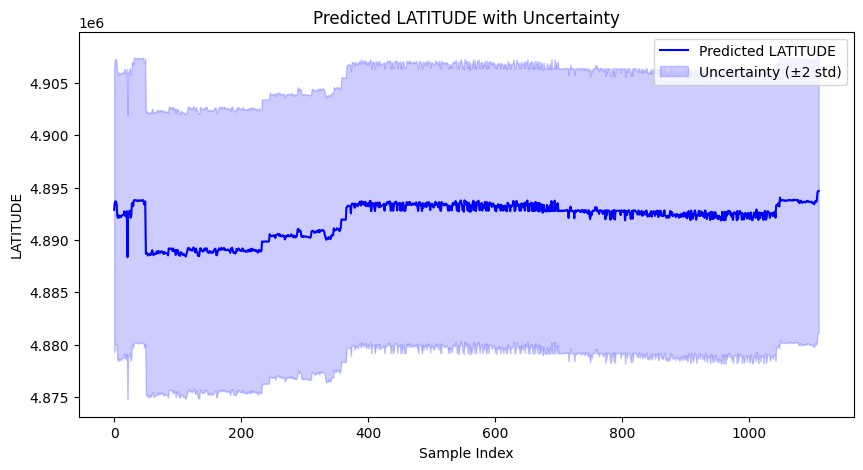

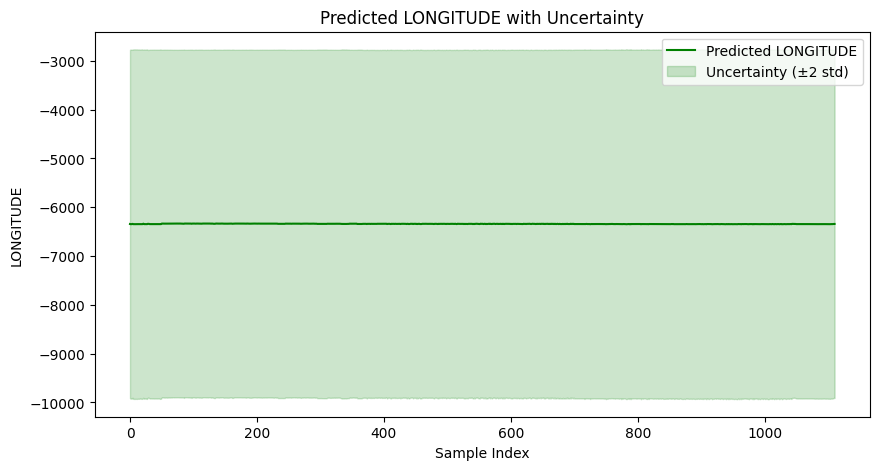

In [ ]:
import matplotlib.pyplot as plt

# Extracting LATITUDE predictions and uncertainties
latitude_means = mean_predictions[:, 0].numpy()
latitude_stds = std_predictions[:, 0].numpy()

# Index for x-axis
index = range(len(latitude_means))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(index, latitude_means, label='Predicted LATITUDE', color='blue')
plt.fill_between(index,
                 latitude_means - 2 * latitude_stds,
                 latitude_means + 2 * latitude_stds,
                 color='blue', alpha=0.2, label='Uncertainty (±2 std)')

plt.xlabel('Sample Index')
plt.ylabel('LATITUDE')
plt.title('Predicted LATITUDE with Uncertainty')
plt.legend()
plt.show()

# Extracting LONGITUDE predictions and uncertainties
longitude_means = mean_predictions[:, 1].numpy()
longitude_stds = std_predictions[:, 1].numpy()

# Index for x-axis
index = range(len(longitude_means))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(index, longitude_means, label='Predicted LONGITUDE', color='green')
plt.fill_between(index,
                 longitude_means - 2 * longitude_stds,
                 longitude_means + 2 * longitude_stds,
                 color='green', alpha=0.2, label='Uncertainty (±2 std)')

plt.xlabel('Sample Index')
plt.ylabel('LONGITUDE')
plt.title('Predicted LONGITUDE with Uncertainty')
plt.legend()
plt.show()

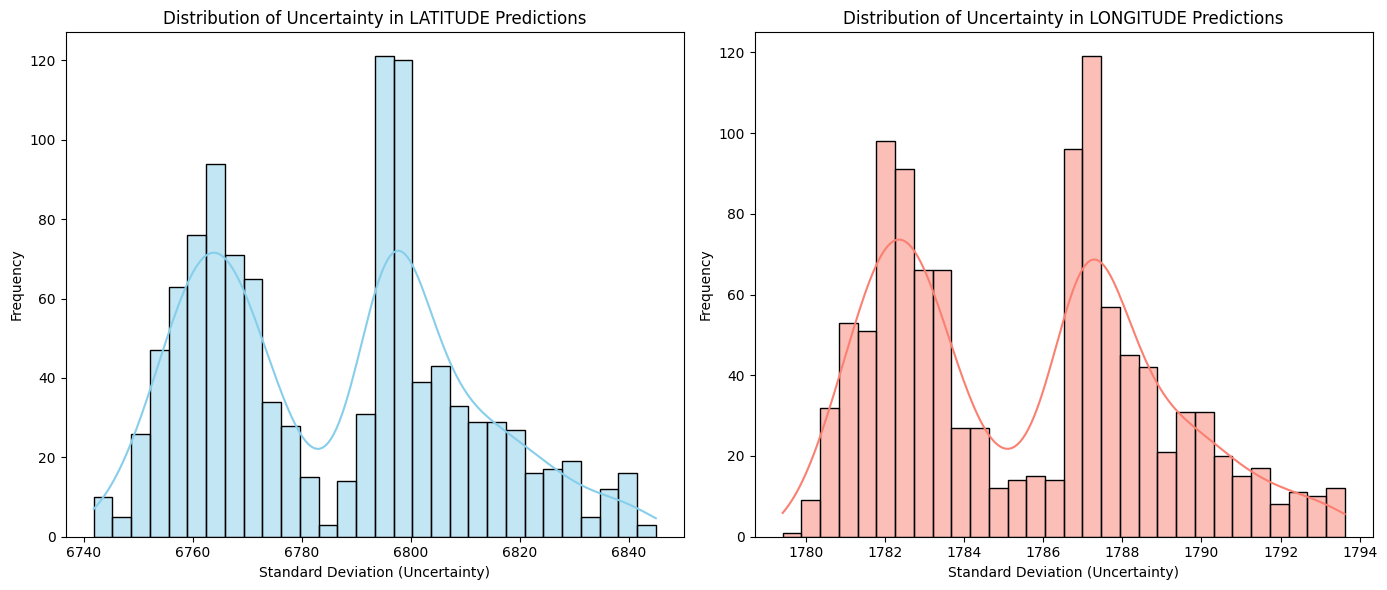

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_uncertainty_distribution_ensemble(std_predictions):
    lat_std = std_predictions[:, 0].numpy()  # Uncertainties for LATITUDE
    lon_std = std_predictions[:, 1].numpy()  # Uncertainties for LONGITUDE

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plotting the distribution of uncertainties for LATITUDE
    sns.histplot(lat_std, bins=30, kde=True, ax=axs[0], color='skyblue')
    axs[0].set_title('Distribution of Uncertainty in LATITUDE Predictions')
    axs[0].set_xlabel('Standard Deviation (Uncertainty)')
    axs[0].set_ylabel('Frequency')

    # Plotting the distribution of uncertainties for LONGITUDE
    sns.histplot(lon_std, bins=30, kde=True, ax=axs[1], color='salmon')
    axs[1].set_title('Distribution of Uncertainty in LONGITUDE Predictions')
    axs[1].set_xlabel('Standard Deviation (Uncertainty)')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_uncertainty_distribution_ensemble(std_predictions)